## Imports

In [1]:
from scopes.scheduler_components import Program, Merit, Target, Night
import scopes.merits as merits
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import astroplan
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord
import astropy.units as u

# from tqdm.notebook import tqdm
import scopes.scheduler as scheduler
from datetime import timedelta

## Setup

In [2]:
# Define the programs
color_pallette = itertools.cycle([mcolors.rgb2hex(color) for color in plt.get_cmap("Set2").colors])

# Eventually this would be imported from the gitlab with the files.
prog600 = Program(600, "COR", 0.034, next(color_pallette))
prog703 = Program(703, "COR", 0.144, next(color_pallette))
prog708 = Program(708, "COR", 0.062, next(color_pallette))
prog714 = Program(714, "COR", 0.045, next(color_pallette))
prog500 = Program(500, "COR", 0.205, next(color_pallette))
prog410 = Program(410, "CAM", 0.161, next(color_pallette))

In [3]:
start_datetime = Time("2023-10-20 03:00:00")

In [4]:
# Time(datetime.combine(date(2023, 10, 20), datetime.min.time()))
start_datetime.datetime.date()
# Define global observer location
lasilla = astroplan.Observer.at_site("lasilla")

night = Night(
    start_datetime.datetime.date() - timedelta(days=1),
    observations_within="nautical",
    observer=lasilla,
)

print(night)

Night(Date: 2023-10-19,
      Sunset: 2460237.4519841406,
      Sunrise: 2460237.9196989094,
      Civil evening: 2460237.471636101,
      Nautical evening: 2460237.4916359833,
      Astronomical evening: 2460237.5121279177,
      Civil morning: 2460237.9000553214,
      Nautical morning: 2460237.880061798,
      Astronomical morning: 2460237.859571456,
      Observations within: 'nautical')


### Define the merits

In [5]:
# Define merits
# cadence_merit = Merit(
#     "Cadence",
#     merits.cadence,
#     merit_type="efficiency",
#     parameters={"delay": TimeDelta(4 * u.day), "alpha": 0.05},
# )
airmass_merit = Merit("Airmass", merits.airmass, merit_type="veto", parameters={"max": 1.8})
altitude_merit = Merit("Altitude", merits.altitude, merit_type="veto")
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto")
culmination_merit = Merit("Culmination", merits.culmination, merit_type="efficiency")
egress_merit = Merit("Egress", merits.egress, merit_type="efficiency")
riseset_merit = Merit("RiseSet", merits.rise_set, merit_type="efficiency")
culmapping_merit = Merit("CulMapping", merits.culmination_mapping, merit_type="efficiency")

In [6]:
# merits_list = [airmass_merit, altitude_merit,
#                at_night_merit, culmination_merit, egress_merit]
# merits_list = [airmass_merit, altitude_merit, at_night_merit, culmination_merit]
# merits_list = [airmass_merit, altitude_merit, at_night_merit, culmination_merit, riseset_merit]
merits_list = [airmass_merit, altitude_merit, at_night_merit, culmapping_merit]

### Load the targets

In [7]:
pct_keep = 0.75

Targets from 600

In [8]:
targets_600 = load_program(
    "programs/specific_date/Prog600COR_2023-10-19_obsinfo.csv",
    prog600,
    merits_list,
    pct_keep=pct_keep,
)
len(targets_600)

4

Targets from 708

In [9]:
targets_708 = load_program(
    "programs/specific_date/Prog708COR_2023-10-19_obsinfo.csv",
    prog708,
    merits_list,
    pct_keep=pct_keep,
)
len(targets_708)

15

Targets from 714

In [10]:
targets_714 = load_program(
    "programs/specific_date/Prog714COR_2023-10-19_obsinfo.csv",
    prog714,
    merits_list,
    pct_keep=pct_keep,
)
len(targets_714)

64

Targets from 500

In [11]:
cat500 = pd.read_csv("programs/specific_date/Prog500COR_test.csv", skiprows=(1,))

In [12]:
targets_500 = []
for i, tar in cat500.iterrows():
    if tar["observable during the night"]:
        # Use astroquery Simbad to get the coordinates
        skycoord = SkyCoord.from_name(tar["TIC"])
        merit_list = [airmass_merit, altitude_merit, at_night_merit, culmination_merit]
        phases = []
        if not np.isnan(tar["Phase1"]):
            phases.append(tar["Phase1"])
        if not np.isnan(tar["Phase2"]):
            phases.append(tar["Phase2"])
        phase_merit = Merit(
            "Phase",
            merits.periodic_gaussian,
            merit_type="efficiency",
            parameters={
                "epoch": tar["Epoch"] + 2_400_000,
                "period": tar["Period"],
                "sigma": 0.1,
                "phases": phases,
            },
        )
        merit_list.append(phase_merit)
        target = Target(
            tar["TOI"],
            prog500,
            coords=skycoord,
            # last_obs=(start_datetime - 5 * u.day).jd,
            exposure_time=0.002,
            priority=tar["Priority"],
        )
        target.add_merits(merit_list)
        targets_500.append(target)

In [13]:
print(targets_500[11])

Target(Name: TOI-2304,
       Program: 500,
       Coordinates: (339.436, -30.608),
       Priority: 1.0,
       Fairness Merits: [],
       Veto Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {})],
       Efficiency Merits: [Merit(Culmination, efficiency, {}), Merit(Phase, efficiency, {'epoch': 2459063.80518, 'period': 9.4090393, 'sigma': 0.1, 'phases': [0.25, 0.75]})])


Targets from 410CAM

In [14]:
cat410_raw = pd.read_csv("programs/specific_date/Prog410CAM_test.csv")
cat410_raw.head()

,Target,RA_deg,DEC_deg,priority,cadence,airmass
0,J0158-4325,29.6724,-43.417800,0,2,1.5
1,J0235-2433,38.8642,-24.553800,0,2,1.5
2,PSJ0259-2338,44.8899,-23.633800,0,2,1.5
3,HE0435-1223,69.5619,-12.287450,0,2,1.5
4,J0457-7820,74.2500,-78.333333,0,2,1.5


In [15]:
from astropy.coordinates import Angle

cat410 = (
    cat410_raw.assign(
        RA_hms=lambda df: Angle(df["RA_deg"], unit=u.deg).to_string(unit=u.hour, sep=":")
    )
    .assign(DEC_dms=lambda df: Angle(df["DEC_deg"], unit=u.deg).to_string(unit=u.degree, sep=":"))
    .assign(cadence=3)
)
cat410["observable during the night"] = True
cat410.loc[8:14, "observable during the night"] = False
cat410["coordinates (DACE)"] = cat410["RA_hms"] + " / " + cat410["DEC_dms"]
cat410["last_obs"] = (start_datetime - 5 * u.day).jd
cat410["cadence percentage overdue [%]"] = (
    (start_datetime.jd - (cat410["last_obs"] + cat410["cadence"])) * 100 / cat410["cadence"]
)
cat410.drop(columns=["RA_deg", "DEC_deg", "RA_hms", "DEC_dms"], inplace=True)
cat410.rename(columns={"Target": "catalog name"}, inplace=True)
cat410.head()

,catalog name,priority,cadence,airmass,observable during the night,coordinates (DACE),last_obs,cadence percentage overdue [%]
0,J0158-4325,0,3,1.5,True,1:58:41.376 / -43:25:04.08,2460232.625,66.666667
1,J0235-2433,0,3,1.5,True,2:35:27.408 / -24:33:13.68,2460232.625,66.666667
2,PSJ0259-2338,0,3,1.5,True,2:59:33.576 / -23:38:01.68,2460232.625,66.666667
3,HE0435-1223,0,3,1.5,True,4:38:14.856 / -12:17:14.82,2460232.625,66.666667
4,J0457-7820,0,3,1.5,True,4:57:00 / -78:20:00,2460232.625,66.666667


In [16]:
cat410.to_csv("programs/specific_date/Prog410CAM_2023-10-19_obsinfo.csv", sep="\t", index=False)

In [17]:
targets_410 = load_program(
    "programs/specific_date/Prog410CAM_2023-10-19_obsinfo.csv", prog410, merits_list, pct_keep=1.0
)
len(targets_410)

11

In [18]:
print(targets_410[2])

Target(Name: PSJ0259-2338,
       Program: 410,
       Coordinates: (44.890, -23.634),
       Priority: 1.0,
       Fairness Merits: [],
       Veto Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {})],
       Efficiency Merits: [Merit(CulMapping, efficiency, {})])


### Build the observations

In [19]:
# Merge the two programs
targets_all = targets_600 + targets_708 + targets_714 + targets_500 + targets_410

In [20]:
obs_600 = build_observations(
    targets_600,
    start_datetime.jd,
    night,
    TimeDelta(20 * u.min).value,
    "programs/specific_date/obs_600.pkl",
)

In [21]:
obs_708 = build_observations(
    targets_708,
    start_datetime.jd,
    night,
    TimeDelta(15 * u.min).value,
    "programs/specific_date/obs_708.pkl",
)

In [22]:
obs_714 = build_observations(
    targets_714,
    start_datetime.jd,
    night,
    TimeDelta(15 * u.min).value,
    "programs/specific_date/obs_714.pkl",
)

In [23]:
obs_500 = build_observations(
    targets_500,
    start_datetime.jd,
    night,
    TimeDelta(40 * u.min).value,
    "programs/specific_date/obs_500.pkl",
)

In [24]:
obs_410 = build_observations(
    targets_410,
    start_datetime.jd,
    night,
    TimeDelta(33 * u.min).value,
    "programs/specific_date/obs_410.pkl",
)

In [25]:
test_observations = obs_600 + obs_708 + obs_714 + obs_500 + obs_410

## Test the merits

In [26]:
test_obs = test_observations[0]
print(test_obs)
print(test_obs.target)

Observation(Target: HD1581,
            Start time: 2460237.625,
            Exposure time: 0.013888888888888888,
            Score: 0.0)
Target(Name: HD1581,
       Program: 600,
       Coordinates: (5.018, -64.875),
       Priority: 1.0,
       Fairness Merits: [],
       Veto Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {})],
       Efficiency Merits: [Merit(CulMapping, efficiency, {})])


In [27]:
# print(f"Cadence merit = {cadence_merit.evaluate(test_obs, verbose=True)}")

In [28]:
print(f"Airmass merit = {airmass_merit.evaluate(test_obs)}")

Airmass merit = True


In [29]:
print(f"Altitude merit = {altitude_merit.evaluate(test_obs)}")

Altitude merit = True


In [30]:
print(f"Culmination merit = {culmination_merit.evaluate(test_obs, verbose=True)}")

Current altitude: 54.47529253685186
Max altitude: 54.51171089210749
Min altitude: 26.500720105594215
Altitude proportion: 0.9986998547986685
Culmination merit = 0.9986998547986685


In [31]:
print(f"Egress merit = {egress_merit.evaluate(test_observations[16], verbose=True)}")

Current time: 2460237.625
First time: 2460237.5744695794
Last time: 2460238.0438332227
Observable range proportion: 0.1076572958625779
Egress merit = 0.7846854082748442


In [32]:
print(f"Phase merit = {phase_merit.evaluate(obs_500[5])}")

Phase merit = 0.9901382884907192


In [33]:
print(f"RiseSet merit = {riseset_merit.evaluate(obs_708[9], verbose=True)}")

cross_time = 0.30764965491295126
merit = 1.3847006901740975
RiseSet merit = 1.3847006901740975


In [34]:
test_obs.feasible()
test_obs.evaluate_score(verbose=True)

Fairness: 1.0
Sensibility: 1.0
Efficiency: 0.9859391366531605
Rank score: 0.9859391366531605


0.9859391366531605

# Test the Schedulers

In [35]:
# Create the plan
plan_start = night.nautical_evening

## Simple greedy search

Greedy search is the equivalent of using `generateQ` with `K=1`

In [36]:
gQ_scheduler = scheduler.generateQ(plan_start)

# Create the plan
greedy_plan = gQ_scheduler.run(test_observations, max_plan_length=None, K=1)

In [37]:
greedy_plan.print_stats()

Length = 31
Score = 0.988655
Evaluation = 0.917364
Overhead time = 0:28:56.169214
Overhead ratio = 0.05575
Observation time = 8:39:00
Observation ratio = 0.92789


In [38]:
print(greedy_plan)

Plan for the night of 2023-10-19 (Times in UTC)
--------------------------------------------------

#     Program ID  Target              Start time   (Exp time)
 1:   708 COR     HD191391            23:47:57     (0:15:00) 
 2:   410 CAM     DES2038-4008        00:06:17     (0:33:00) 
 3:   708 COR     BD-104886           00:42:47     (0:15:00) 
 4:   714 COR     HD179522            00:58:26     (0:15:00) 
 5:   708 COR     TYC6283-800-1       01:14:01     (0:15:00) 
 6:   714 COR     HD173540            01:29:33     (0:15:00) 
 7:   714 COR     HD201933            01:45:14     (0:15:00) 
 8:   714 COR     HD205123            02:00:38     (0:15:00) 
 9:   714 COR     HD209523            02:16:11     (0:15:00) 
10:   714 COR     HD213729            02:31:36     (0:15:00) 
11:   714 COR     HD215104            02:46:59     (0:15:00) 
12:   714 COR     HD218266            03:02:23     (0:15:00) 
13:   714 COR     HD223549            03:17:48     (0:15:00) 
14:   714 COR     HD770         

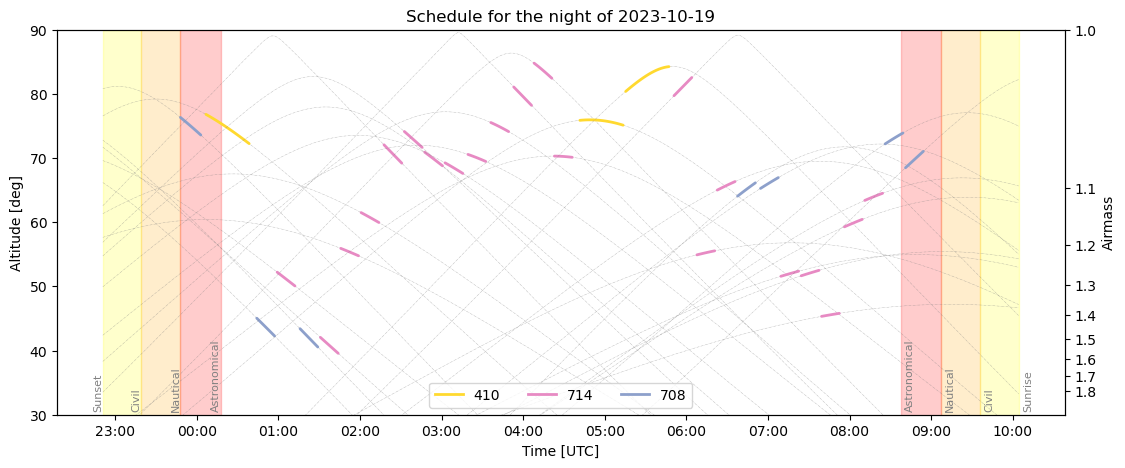

In [39]:
greedy_plan.plot()

In [40]:
# greedy_plan.plot_interactive()

## Greedy Look-Ahead with Top-K Selection: `generateQ`

This is similar to the simple greedy search but with a lookahead of the top K observations at each step. This approach explores different permutations of the top K observations and thus chooses the best one by looking forward.

In [41]:
gQ_scheduler = scheduler.generateQ(plan_start)

# Create the plan
gQ_plan = gQ_scheduler.run(test_observations, max_plan_length=None, K=5)

In [42]:
gQ_plan.print_stats()

Length = 32
Score = 0.989333
Evaluation = 0.912686
Overhead time = 0:28:42.672778
Overhead ratio = 0.05564
Observation time = 8:36:00
Observation ratio = 0.92253


In [43]:
print(gQ_plan)

Plan for the night of 2023-10-19 (Times in UTC)
--------------------------------------------------

 #      Program ID      Target                  Start time   (Exp time)
 1:	714COR	HD173540            	23:47:57     (0:15:00)
 2:	410CAM	DES2038-4008        	00:06:21     (0:33:00)
 3:	708COR	BD-104886           	00:42:50     (0:15:00)
 4:	714COR	HD179522            	00:58:29     (0:15:00)
 5:	708COR	TYC6283-800-1       	01:14:05     (0:15:00)
 6:	714COR	HD173875            	01:29:33     (0:15:00)
 7:	714COR	HD201933            	01:45:16     (0:15:00)
 8:	714COR	HD205123            	02:00:40     (0:15:00)
 9:	714COR	HD209661            	02:16:05     (0:15:00)
10:	714COR	HD213729            	02:31:30     (0:15:00)
11:	714COR	HD215104            	02:46:53     (0:15:00)
12:	714COR	HD218266            	03:02:17     (0:15:00)
13:	714COR	HD223549            	03:17:42     (0:15:00)
14:	714COR	HD770               	03:36:00     (0:15:00)
15:	714COR	HD1737              	03:51:26     (0:15:00)
16:

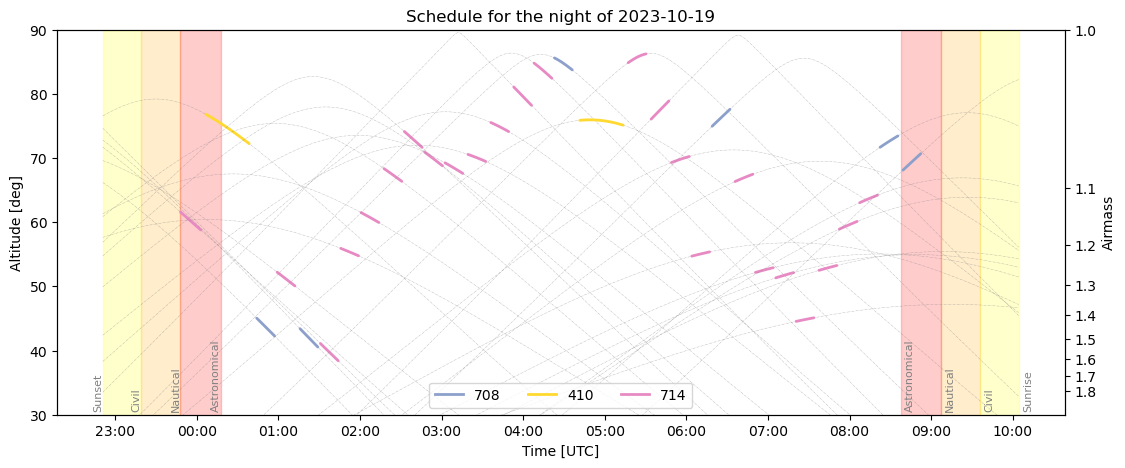

In [44]:
gQ_plan.plot()

## Recursive Dynamic Programming

In [77]:
# dpplanner = scheduler.DPPlanner()

# dpplan = dpplanner.dp_recursion(test_observations_noegress,
#                                 Plan(),
#                                 max_plan_length=10,
#                                 K = 4)

In [78]:
# print(f"Total recursion calls: {dpplanner.total_counter}")
# print(f"Saved recursion calls: {dpplanner.saved_state_counter}")

# print(dpplan[1])

In [79]:
# dpplan[1].plot()

## Beam Search

In [130]:
beamsearch = scheduler.BeamSearchPlanner(plan_start)

bs_plan = beamsearch.dp_beam_search(test_observations, max_plan_length=None, K=4)

In [131]:
bs_plan.print_stats()

Length = 27
Score = 0.783722
Evaluation = 0.742621
Overhead time = 0:28:24.093951
Overhead ratio = 0.05359
Observation time = 8:50:00
Observation ratio = 0.94756


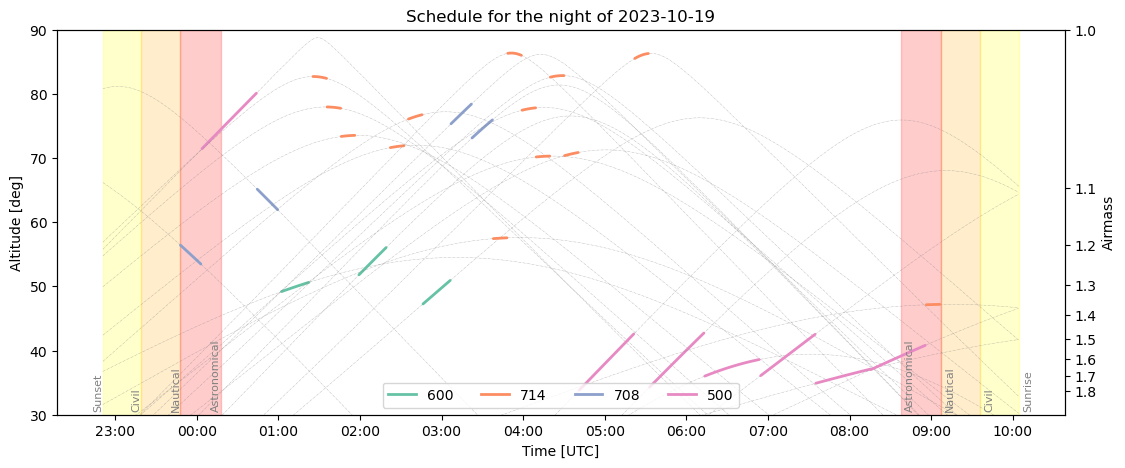

In [132]:
bs_plan.plot()

## Random tests